In [334]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from datatools import DataGrapher


%matplotlib inline

In [335]:
#Bring in the data

nba = pd.read_csv('./data/nba_analysis_data.csv')
nba.dropna(inplace = True)

In [336]:
features = ['home_payout', 'away_payout','feature_1', 'feature_2', 
            'feature_3' ,'feature_4', 'feature_5', 'feature_6',
            'feature_7', 'feature_8', 
            'feature_9','feature_10', 'feature_11', 'feature_12', 
            'feature_13', 'feature_14', 'feature_15', 'feature_16',
            'feature_17', 'feature_18', 'feature_19']

In [337]:
nba

,dataset,date,teams,home_starter5,crew_referees,spread,total,moneyline,away_team,away_pace,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,2006-2007 Regular Season,2007-02-20,Chicago,B. Wallace,Sean Wright,-7.5,191.5,-370.0,Atlanta,92.3,...,0,0,0,0,0,0,0,0,0,0
1,2006-2007 Regular Season,2007-04-14,Cleveland,S. Pavlovic,Jess Kersey,-13.5,187.0,0.0,Atlanta,88.0,...,0,0,0,0,0,0,0,0,0,0
2,2006-2007 Regular Season,2007-02-26,Dallas,J. Terry,Mark Ayotte,-14.0,191.0,0.0,Atlanta,84.8,...,0,0,0,0,0,0,0,0,0,0
3,2006-2007 Regular Season,2006-12-06,Denver,J. Smith,Robbie Robinson,-10.0,213.0,-800.0,Atlanta,95.4,...,0,0,0,0,0,0,0,0,0,0
4,2006-2007 Regular Season,2006-11-22,Detroit,R. Wallace,Bennie Adams,-8.0,188.0,-265.0,Atlanta,89.3,...,0,0,0,0,0,0,0,0,0,0
5,2006-2007 Regular Season,2006-12-23,Detroit,R. Wallace,Jason Phillips,-9.5,188.0,-650.0,Atlanta,83.7,...,0,0,0,0,0,0,0,0,0,0
6,2006-2007 Regular Season,2007-02-11,Golden_State,S. Jackson,Leon Wood,-5.0,205.0,-210.0,Atlanta,98.9,...,0,0,0,0,0,0,0,0,0,0
7,2006-2007 Regular Season,2006-12-29,Houston,D. Mutombo,Derrick Collins,-9.0,178.0,-420.0,Atlanta,84.8,...,0,0,0,0,0,0,0,0,0,0
8,2006-2007 Regular Season,2007-01-09,Indiana,J. Tinsley,Zach Zarba,-9.5,188.5,-530.0,Atlanta,84.9,...,0,0,0,0,0,0,0,0,0,0
9,2006-2007 Regular Season,2007-03-17,Indiana,J. Tinsley,Robbie Robinson,-5.0,188.5,-240.0,Atlanta,87.0,...,0,0,1,0,0,0,0,0,0,0


In [338]:

X = nba.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv',
                       'home_starter5', 'win_margin_ratio',
                       'away_starter2', 'away_starter3',
                       'away_starter4', 'away_starter5',
                       'ref_1', 'ref_3', 'crew_referees',
                      'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover','feature_1', 
            'feature_2', 
            'feature_3' ,'feature_4', 'feature_5', 'feature_6',
            'feature_7', 'feature_8', 'teams', 'away_team',
            'feature_9','feature_10', 'feature_11', 'feature_12', 
            'feature_13', 'feature_14', 'feature_15', 'feature_16',
            'feature_17', 'feature_18', 'feature_19',
                       'home_payout', 'away_payout'])


#X = nba[features]
y = nba['cover']

In [339]:

nba.shape

(9198, 206)

In [340]:
np.where(X.values >= np.finfo(np.float64).max)

(array([], dtype=int64), array([], dtype=int64))

In [341]:

#create interactions and squared terms
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names(X.columns))

In [342]:
#splitting data for a train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, 
                                                    y ,
                                                    stratify=y,
                                                    random_state = 31)

In [343]:
X_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 7973 to 4411
Data columns (total 13861 columns):
1                                              float64
spread                                         float64
total                                          float64
moneyline                                      float64
mov_5_1q                                       float64
last_1q                                        float64
mov_5_2q                                       float64
last_2q                                        float64
mov_5_3q                                       float64
last_3q                                        float64
mov_5_4q                                       float64
last_4q                                        float64
mov_5_ot1                                      float64
last_ot1                                       float64
mov_5_ot2                                      float64
last_ot2                                       float64
mov_5_o

In [344]:
X_train.shape


(6898, 13861)

In [345]:
#scaling data to use in various other methods
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [346]:
from sklearn.decomposition import PCA

In [347]:
pc = PCA(n_components=320)
X_train_pc = pc.fit_transform(X_train_scaled)
X_test_pc = pc.transform(X_test_scaled)


In [348]:
var_exp = pc.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [8.02885099e-02 7.01371677e-02 3.39650147e-02 2.68499615e-02
 2.44227203e-02 2.39803126e-02 2.31503999e-02 2.20053801e-02
 1.95194880e-02 1.86657571e-02 1.71341896e-02 1.67209663e-02
 1.55437247e-02 1.37106005e-02 1.28996645e-02 1.26109698e-02
 1.18469122e-02 1.16695488e-02 1.15290755e-02 1.13245649e-02
 1.09066174e-02 1.05218115e-02 1.02136900e-02 1.01790957e-02
 9.87786449e-03 9.69534470e-03 9.65492780e-03 9.56780156e-03
 9.47820061e-03 9.41582960e-03 9.30368487e-03 8.92276352e-03
 8.83991615e-03 8.74495527e-03 8.65259028e-03 8.58895987e-03
 8.42967176e-03 8.33478483e-03 8.29837941e-03 8.20853084e-03
 8.16037025e-03 8.08597183e-03 7.94731511e-03 7.83284711e-03
 7.76365652e-03 7.55460449e-03 7.49875158e-03 7.39572238e-03
 7.21058271e-03 7.01664680e-03 6.54800012e-03 6.16916192e-03
 6.11394407e-03 6.03027817e-03 5.84708694e-03 5.68790356e-03
 5.59967314e-03 5.41118981e-03 5.24759911e-03 5.12816582e-03
 5.07536821e-03 4.94585395e-03 4.89110172e-03 4.71237

In [349]:
lr = LogisticRegressionCV(Cs=[1,10] , 
                          penalty='l2', 
                          solver ='lbfgs', 
                          cv =3 )
lr.fit(X_train_pc, y_train)
lr.score(X_train_pc, y_train)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. 

0.5806030733545955

In [350]:
lr.score(X_test_pc, y_test)

0.5147826086956522

In [351]:
y_hat_lr = lr.predict(X_test_pc)
y_hat_lrp = lr.predict_proba(X_test_pc)


In [352]:
print(classification_report(y_test, y_hat_lr))

              precision    recall  f1-score   support

           0       0.53      0.62      0.57      1204
           1       0.49      0.40      0.44      1096

   micro avg       0.51      0.51      0.51      2300
   macro avg       0.51      0.51      0.51      2300
weighted avg       0.51      0.51      0.51      2300



In [353]:
confusion_matrix( y_test, y_hat_lr)

array([[741, 463],
       [653, 443]])

### Naive Bayes

Model seems to work best with bare bones information.  More information confused the model.

In [354]:
nb = GaussianNB()
nb_params = {
    'var_smoothing' : [.05,.1,.15 ] 
    }

In [355]:
gs = GridSearchCV(nb, param_grid=nb_params, scoring='precision')
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.4739689276916861
{'var_smoothing': 0.15}


In [356]:
gs.score(X_test_pc, y_test)

0.47681224673570466

In [357]:
y_hat_nb = gs.predict(X_test_pc)
y_hat_nbp = gs.predict_proba(X_test_pc)

In [358]:
print(classification_report(y_test, y_hat_nb))

              precision    recall  f1-score   support

           0       0.53      0.03      0.07      1204
           1       0.48      0.97      0.64      1096

   micro avg       0.48      0.48      0.48      2300
   macro avg       0.50      0.50      0.35      2300
weighted avg       0.51      0.48      0.34      2300



In [359]:
confusion_matrix( y_test, y_hat_nb)

array([[  42, 1162],
       [  37, 1059]])

In [360]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [361]:
model = Sequential()
model.add(Dense(300, 
                activation = 'relu',
                input_dim = X_train_scaled.shape[1]))
#model.add(Dense(200, activation = 'relu'))

#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output layer 

In [362]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
model.fit(X_train_scaled, 
          y_train, epochs =15, 
          batch_size= 128, 
          validation_data=(X_test_scaled, y_test))

Train on 6898 samples, validate on 2300 samples
Epoch 1/15
6898/6898 [==============================] - 5s 659us/step - loss: 2.8671 - acc: 0.5032 - val_loss: 1.9255 - val_acc: 0.5083
Epoch 2/15
6898/6898 [==============================] - 4s 587us/step - loss: 1.4144 - acc: 0.5668 - val_loss: 1.4813 - val_acc: 0.4835
Epoch 3/15
6898/6898 [==============================] - 4s 624us/step - loss: 0.9347 - acc: 0.6322 - val_loss: 1.2359 - val_acc: 0.5065
Epoch 4/15
6898/6898 [==============================] - 5s 665us/step - loss: 0.7810 - acc: 0.6824 - val_loss: 1.1611 - val_acc: 0.4957
Epoch 5/15
6898/6898 [==============================] - 4s 635us/step - loss: 0.6878 - acc: 0.7412 - val_loss: 1.1923 - val_acc: 0.5039
Epoch 6/15
6898/6898 [==============================] - 4s 541us/step - loss: 0.6567 - acc: 0.7509 - val_loss: 1.2431 - val_acc: 0.5109
Epoch 7/15
6898/6898 [==============================] - 4s 542us/step - loss: 0.6142 - acc: 0.7814 - val_loss: 1.2298 - val_acc: 0.4939


In [363]:
y_hat_nn = model.predict(X_test_scaled)
y_hat_nnp = model.predict_proba(X_test_scaled)

In [364]:
rf = RandomForestClassifier()
rf_params = {'max_depth' : [50,120],
             'min_samples_split' : [125, 150]}

In [365]:
gs = GridSearchCV(rf, param_grid=rf_params)
gs.fit(X_train_scaled, y_train)
print(gs.best_score_)
print(gs.best_params_)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0

0.5107277471730937
{'max_depth': 50, 'min_samples_split': 125}


In [366]:
gs.score(X_test_scaled, y_test)

0.5004347826086957

In [367]:
y_hat_rf = gs.predict(X_test_scaled)
y_hat_rfp = gs.predict_proba(X_test_scaled)

In [368]:
print(classification_report(y_test, y_hat_rf))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56      1204
           1       0.47      0.39      0.43      1096

   micro avg       0.50      0.50      0.50      2300
   macro avg       0.50      0.50      0.49      2300
weighted avg       0.50      0.50      0.49      2300



In [369]:
confusion_matrix( y_test, y_hat_rf)

array([[725, 479],
       [670, 426]])

In [370]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves 
#Random Forest
X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label_rf'] = y_hat_rf
X_test.loc[:, 'predicted_proba_rfp'] = y_hat_rfp[:, 1]

#Bayesian

X_test.loc[:, 'predicted_label_nb'] = y_hat_nb
X_test.loc[:, 'predicted_proba_nbp'] = y_hat_nbp[:, 1]

X_test.loc[:, 'predicted_label_lr'] = y_hat_lr
X_test.loc[:, 'predicted_proba_lrp'] = y_hat_lrp[:, 1]

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [371]:
from sklearn.metrics import roc_curve, auc

In [375]:
fpr, tpr, _ = roc_curve(y_test, X_test['predicted_proba_nbp'])
roc_auc = auc(fpr, tpr)

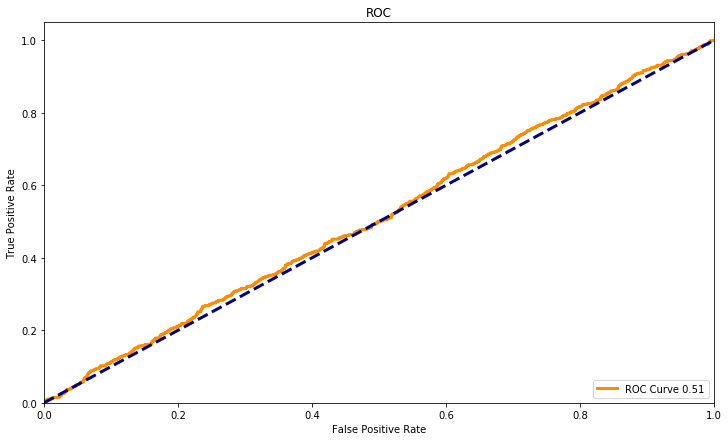

In [376]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [374]:
for prob in range(40, 65, 1):
    proba = prob/100
    
    X_test.loc[:, 'predicted_label']= X_test['predicted_proba_lrp'].map(
    lambda p: 1 if p > proba else 0)
    
#     X_train.loc[:, 'predicted_label']= X_train['predicted_proba_rfp'].map(
#     lambda p: 1 if p > proba else 0)
    
#    results = X_test[X_test['predicted_label']==1]
    print('Test  ' + str(proba))
    print (confusion_matrix(y_test, X_test['predicted_label']))
#    results_neg = X_test[X_test['predicted_label']==0]
#    print ("Return of Home Games: ", results_neg.home_payout.sum())
#     print(' Train  ' + str(proba))
#     print(confusion_matrix(y_train, X_train['predicted_label']))

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Test  0.4
[[275 929]
 [228 868]]
Test  0.41
[[314 890]
 [258 838]]
Test  0.42
[[360 844]
 [297 799]]
Test  0.43
[[403 801]
 [329 767]]
Test  0.44
[[447 757]
 [370 726]]
Test  0.45
[[501 703]
 [429 667]]
Test  0.46
[[551 653]
 [475 621]]
Test  0.47
[[597 607]
 [512 584]]
Test  0.48
[[658 546]
 [562 534]]
Test  0.49
[[696 508]
 [600 496]]
Test  0.5
[[741 463]
 [653 443]]
Test  0.51
[[803 401]
 [693 403]]
Test  0.52
[[850 354]
 [734 362]]
Test  0.53
[[889 315]
 [787 309]]
Test  0.54
[[928 276]
 [827 269]]
Test  0.55
[[961 243]
 [867 229]]
Test  0.56
[[1001  203]
 [ 895  201]]
Test  0.57
[[1024  180]
 [ 921  175]]
Test  0.58
[[1052  152]
 [ 944  152]]
Test  0.59
[[1067  137]
 [ 970  126]]
Test  0.6
[[1093  111]
 [ 984  112]]
Test  0.61
[[1107   97]
 [ 994  102]]
Test  0.62
[[1116   88]
 [1015   81]]
Test  0.63
[[1131   73]
 [1028   68]]
Test  0.64
[[1141   63]
 [1041   55]]
